In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:

class UNet(nn.Module):
    def __init__(self, img_size=28, in_channels=1, out_channels=1, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # 下采样路径
        self.down1 = self.conv_block(in_channels, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        
        # 中间层
        self.middle = self.conv_block(512, 1024)
        
        # 上采样路径
        self.up1 = self.conv_block(1024 + 512, 512)
        self.up2 = self.conv_block(512 + 256, 256)
        self.up3 = self.conv_block(256 + 128, 128)
        self.up4 = self.conv_block(128 + 64, 64)
        
        # 输出层
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # 用于时间嵌入的线性层
        self.time_embed = nn.Linear(time_dim, 128)
        self.time_embed2 = nn.Linear(128, 128)
        
        # 图像大小调整
        self.img_size = img_size
        self.final_size = (img_size, img_size)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            nn.GELU()
        )

    def forward(self, x, t_emb):
        # 下采样
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        # 中间层
        x = self.middle(x4)
        
        # 上采样
        x = self.up1(torch.cat([x, x4], dim=1))
        x = self.up2(torch.cat([x, x3], dim=1))
        x = self.up3(torch.cat([x, x2], dim=1))
        x = self.up4(torch.cat([x, x1], dim=1))
        
        # 输出
        return self.final_conv(x)

    def forward_with_time(self, x, t):
        t = t.to(x.device)
        t_emb = self.time_mlp(t.view(-1, 1))  
        t_emb = self.time_embed(t_emb)
        t_emb = self.time_embed2(t_emb)
        return self.forward(x, t_emb)



In [14]:

def get_schedule(T=200):
    beta = torch.linspace(1e-4, 0.02, T)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta, alpha, alpha_bar



In [15]:

def forward_diffusion(x0, t, alpha_bar):
    device = x0.device
    noise = torch.randn_like(x0)
    alpha_t = alpha_bar[t].view(-1, 1, 1, 1).to(device)  # 保持4D形状
    return torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise, noise    #加噪



In [16]:

def train_step(model, x0, alpha_bar, optimizer):
    device = x0.device
    t = torch.randint(0, len(alpha_bar), (x0.shape[0],), device=device)
    xt, noise = forward_diffusion(x0, t, alpha_bar)
    pred_noise = model.forward_with_time(xt, t.float())
    loss = nn.MSELoss()(pred_noise, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()



In [17]:

@torch.no_grad()
def sample(model, shape, T, beta, alpha, alpha_bar, device):
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        t_tensor = torch.full((shape[0],), t, dtype=torch.float32, device=device)
        pred_noise = model.forward_with_time(x, t_tensor)
        
        alpha_t = alpha[t].to(device)
        alpha_bar_t = alpha_bar[t].to(device)
        beta_t = beta[t].to(device)
        
        # DDPM采样公式
        x = (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            x += torch.sqrt(beta_t) * torch.randn_like(x)
    return x



In [18]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1),  # 归一化到[-1, 1]
    transforms.Lambda(lambda x: x.view(1, 28, 28))  # 保持为2D (1,28,28)
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)



In [19]:

T = 200
beta, alpha, alpha_bar = get_schedule(T)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, time_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # 提高学习率
beta, alpha, alpha_bar = beta.to(device), alpha.to(device), alpha_bar.to(device)
os.makedirs('samples', exist_ok=True)

In [20]:

for epoch in range(10):  
    epoch_loss = 0.0
    for i, (imgs, _) in enumerate(trainloader):
        imgs = imgs.to(device)
        loss = train_step(model, imgs, alpha_bar, optimizer)
        epoch_loss += loss
    
    avg_loss = epoch_loss / len(trainloader)
    print(f"Epoch {epoch+1}/50 | Average Loss: {avg_loss:.4f}")
    
    # 保存模型和生成样本
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
        
        # 生成样本
        samples = sample(model, (16, 1, 28, 28), T, beta, alpha, alpha_bar, device)
        samples = samples.view(-1, 1, 28, 28).cpu()
        
        # 保存样本
        plt.figure(figsize=(10, 3))
        for i in range(16):
            plt.subplot(2, 8, i+1)
            plt.imshow(samples[i, 0].numpy(), cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'samples/sample_epoch_{epoch+1}.png')
        plt.close()



Epoch 1/50 | Average Loss: 0.0926
Epoch 2/50 | Average Loss: 0.0594
Epoch 3/50 | Average Loss: 0.0554
Epoch 4/50 | Average Loss: 0.0538
Epoch 5/50 | Average Loss: 0.0527
Epoch 6/50 | Average Loss: 0.0514
Epoch 7/50 | Average Loss: 0.0507
Epoch 8/50 | Average Loss: 0.0499
Epoch 9/50 | Average Loss: 0.0494
Epoch 10/50 | Average Loss: 0.0486


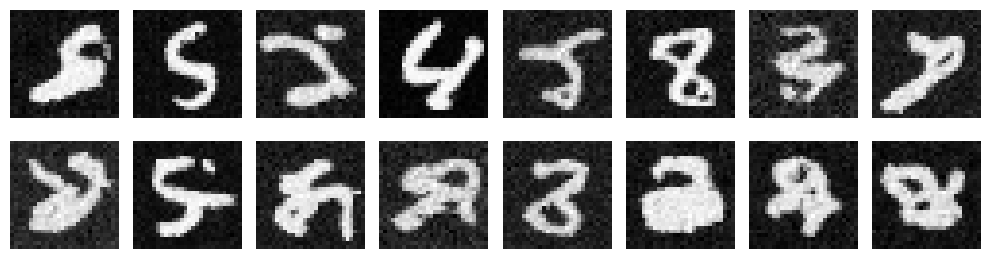

Training completed! Final samples saved as 'samples/final_samples.png'
Models saved as 'model_epoch_*.pth'


In [21]:

samples = sample(model, (16, 1, 28, 28), T, beta, alpha, alpha_bar, device)
samples = samples.view(-1, 1, 28, 28).cpu()

plt.figure(figsize=(10, 3))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(samples[i, 0].numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.savefig('samples/final_samples.png')
plt.show()

print("Training completed! '")
print("Models saved as 'model_epoch_*.pth'")